### Матричные факторизации

В данной работе вам предстоит познакомиться с практической стороной матричных разложений.
Работа поделена на 4 задания:
1. Вам необходимо реализовать SVD разложения используя SGD на explicit данных
2. Вам необходимо реализовать матричное разложения используя ALS на implicit данных
3. Вам необходимо реализовать матричное разложения используя BPR на implicit данных
4. Вам необходимо реализовать матричное разложения используя WARP на implicit данных

Мягкий дедлайн 13 Октября (пишутся замечания, выставляется оценка, есть возможность исправить до жесткого дедлайна)

Жесткий дедлайн 20 Октября (Итоговая проверка)

# Imports

In [1]:
import random
from datetime import datetime

import implicit
import numpy as np
import pandas as pd
import scipy.sparse as sp
from lightfm.datasets import fetch_movielens


# Data

В данной работе мы будем работать с explicit датасетом movieLens, в котором представленны пары user_id movie_id и rating выставленный пользователем фильму

Скачать датасет можно по ссылке https://grouplens.org/datasets/movielens/1m/

In [2]:
ratings = pd.read_csv('ml-1m/ratings.dat', delimiter='::', header=None, 
        names=['user_id', 'movie_id', 'rating', 'timestamp'], 
        usecols=['user_id', 'movie_id', 'rating'], engine='python')

In [3]:
movie_info = pd.read_csv('ml-1m/movies.dat', delimiter='::', header=None, 
        names=['movie_id', 'name', 'category'], engine='python', encoding="utf-8")

Explicit данные

In [4]:
ratings.head(10)

,user_id,movie_id,rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5
5,1,1197,3
6,1,1287,5
7,1,2804,5
8,1,594,4
9,1,919,4


Для того, чтобы преобразовать текущий датасет в Implicit, давайте считать что позитивная оценка это оценка >=4

In [5]:
implicit_ratings = ratings.loc[(ratings['rating'] >= 4)]

In [6]:
implicit_ratings.head(10)

,user_id,movie_id,rating
0,1,1193,5
3,1,3408,4
4,1,2355,5
6,1,1287,5
7,1,2804,5
8,1,594,4
9,1,919,4
10,1,595,5
11,1,938,4
12,1,2398,4


Удобнее работать с sparse матричками, давайте преобразуем DataFrame в CSR матрицы

In [7]:
users = implicit_ratings["user_id"]
movies = implicit_ratings["movie_id"]
user_item = sp.coo_matrix((np.ones_like(users), (users, movies)))
user_item_t_csr = user_item.T.tocsr()
user_item_csr = user_item.tocsr()

# ALS example

## Train

В качестве примера воспользуемся ALS разложением из библиотеки implicit

Зададим размерность латентного пространства равным 64, это же определяет размер user/item эмбедингов

In [8]:
model = implicit.als.AlternatingLeastSquares(factors=64, iterations=100, calculate_training_loss=True)

В качестве loss здесь всеми любимый RMSE

In [9]:
model.fit(user_item_t_csr)

100%|██████████| 100/100 [00:37<00:00,  2.68it/s, loss=0.0135]


## Testing

Построим похожие фильмы по 1 movie_id = Истории игрушек

In [10]:
movie_info.head(5)

,movie_id,name,category
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [11]:
get_similars = lambda item_id, model : [movie_info[movie_info["movie_id"] == x[0]]["name"].to_string() for x in model.similar_items(item_id)]

In [12]:
model.similar_items(1)

[(1, 1.0),
 (3114, 0.80071753),
 (2355, 0.60568184),
 (34, 0.45705056),
 (588, 0.45490992),
 (364, 0.42241606),
 (2384, 0.4127818),
 (1907, 0.39547315),
 (1566, 0.38737085),
 (2687, 0.3817017)]

Как мы видим, симилары действительно оказались симиларами.

Качество симиларов часто является хорошим способом проверить качество алгоритмов.

P.S. Если хочется поглубже разобраться в том как разные алгоритмы формируют разные латентные пространства, рекомендую загружать полученные вектора в tensorBoard и смотреть на сформированное пространство

In [13]:
get_similars(1, model)

['0    Toy Story (1995)',
 '3046    Toy Story 2 (1999)',
 "2287    Bug's Life, A (1998)",
 '33    Babe (1995)',
 '584    Aladdin (1992)',
 '360    Lion King, The (1994)',
 '2316    Babe: Pig in the City (1998)',
 '1839    Mulan (1998)',
 '1526    Hercules (1997)',
 '2619    Tarzan (1999)']

Давайте теперь построим рекомендации для юзеров

Как мы видим юзеру нравится фантастика, значит и в рекомендациях ожидаем увидеть фантастику

In [14]:
get_user_history = lambda user_id, implicit_ratings : [movie_info[movie_info["movie_id"] == x]["name"].to_string() for x in implicit_ratings[implicit_ratings["user_id"] == user_id]["movie_id"]]

In [15]:
get_user_history(4, implicit_ratings)

['3400    Hustler, The (1961)',
 '2883    Fistful of Dollars, A (1964)',
 '1196    Alien (1979)',
 '1023    Die Hard (1988)',
 '257    Star Wars: Episode IV - A New Hope (1977)',
 '1960    Saving Private Ryan (1998)',
 '476    Jurassic Park (1993)',
 '1180    Raiders of the Lost Ark (1981)',
 '1886    Rocky (1976)',
 '1081    E.T. the Extra-Terrestrial (1982)',
 '3350    Thelma & Louise (1991)',
 '3634    Mad Max (1979)',
 '2298    King Kong (1933)',
 '1366    Jaws (1975)',
 '1183    Good, The Bad and The Ugly, The (1966)',
 '2624    Run Lola Run (Lola rennt) (1998)',
 '2879    Goldfinger (1964)',
 '1220    Terminator, The (1984)']

Получилось! 

Мы действительно порекомендовали пользователю фантастику и боевики, более того встречаются продолжения тех фильмов, которые он высоко оценил

In [16]:
get_recommendations = lambda user_id, model : [movie_info[movie_info["movie_id"] == x[0]]["name"].to_string() 
                                               for x in model.recommend(user_id, user_item_csr)]

In [17]:
get_recommendations(4, model)

['585    Terminator 2: Judgment Day (1991)',
 '1271    Indiana Jones and the Last Crusade (1989)',
 '2503    Matrix, The (1999)',
 '1284    Butch Cassidy and the Sundance Kid (1969)',
 '1182    Aliens (1986)',
 '1178    Star Wars: Episode V - The Empire Strikes Back...',
 '3403    Close Encounters of the Third Kind (1977)',
 '1885    French Connection, The (1971)',
 '847    Godfather, The (1972)',
 '2461    Planet of the Apes (1968)']

# My work

Теперь ваша очередь реализовать самые популярные алгоритмы матричных разложений

Что будет оцениваться:
1. Корректность алгоритма
2. Качество получившихся симиларов
3. Качество итоговых рекомендаций для юзера

In [18]:
from factorization import SVD, SVDS, ALS, BPR, WARP

## Testing utils

In [19]:
get_similars = lambda item_id, model : movie_info[movie_info["movie_id"].isin(model.similar_items(item_id))][["name", "category"]]

get_recommendations = lambda user_id, model : movie_info[movie_info["movie_id"].isin(model.recommend(user_id))][["name", "category"]]

get_user_history = lambda user_id, implicit_ratings : movie_info[movie_info["movie_id"].isin(implicit_ratings[implicit_ratings["user_id"] == user_id]["movie_id"])][["name", "category"]]


def test(model):
    item_id = 1
    target = movie_info[movie_info.movie_id == item_id]
    print(f"Similar to {target.name.item()} ({target.category.item()}):")
    sims = model.similar_items(item_id)
    
    for idx, i in enumerate(sims):
        selected = movie_info[movie_info.movie_id == i]
        print(f"{idx + 1}) {selected.name.item()} ({selected.category.item()})")
    
    print()
    
    user_id = 4
    print(f"Recommended movies for user {user_id}:")
    recs = model.recommend(user_id)
    
    for idx, i in enumerate(recs):
        selected = movie_info[movie_info.movie_id == i]
        if len(selected) != 0:
            print(f"{idx + 1}) {selected.name.item()} ({selected.category.item()})")
        else:
            print(f"{idx + 1}) << Not found >>")

## Задание 1. Не использую готовые решения, реализовать SVD разложение используя SGD на explicit данных

In [20]:
user_item_exp = sp.coo_matrix((ratings["rating"], (ratings["user_id"], ratings["movie_id"])))

Iter:  500 | RMSE: 7.56285E-01
Iter:  1000 | RMSE: 6.45276E-01
Iter:  1500 | RMSE: 5.90717E-01
Iter:  2000 | RMSE: 5.59849E-01
Iter:  2500 | RMSE: 5.40168E-01
Iter:  3000 | RMSE: 5.26533E-01
Iter:  3500 | RMSE: 5.16491E-01
Iter:  4000 | RMSE: 5.08743E-01
Iter:  4500 | RMSE: 5.02548E-01
Iter:  5000 | RMSE: 4.97457E-01


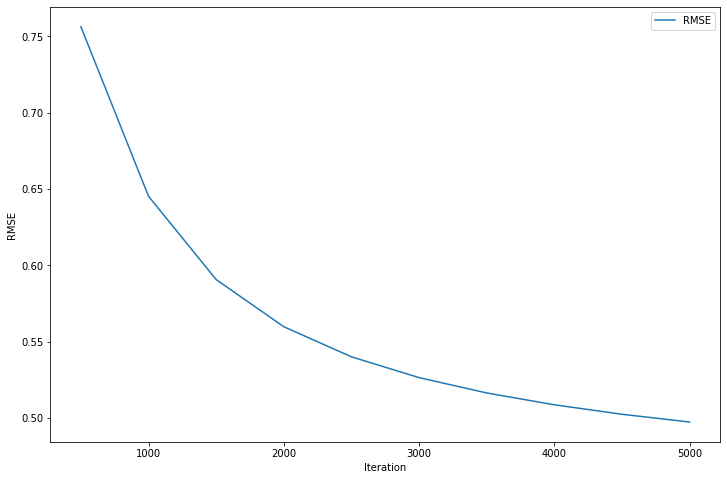

CPU times: user 59min 13s, sys: 1h 16min 15s, total: 2h 15min 28s
Wall time: 21min 26s


In [21]:
%%time
model_svd = SVD(64, iterations=5000, lr=1e-4, verbose=True, weight_decay=1e-2)
model_svd.fit(user_item_exp)  

timestamp = datetime.now()
model_svd.logger.save(f"log.{timestamp.date()}_{timestamp.time()}.csv")
model_svd.logger.plot("iter", "rmse", label="RMSE", x_label="Iteration", y_label="RMSE")

Iter:   10 | RMSE: 6.63762E-01
Iter:   20 | RMSE: 5.80519E-01
Iter:   30 | RMSE: 5.48370E-01
Iter:   40 | RMSE: 5.31707E-01
Iter:   50 | RMSE: 5.20604E-01
Iter:   60 | RMSE: 5.14235E-01
Iter:   70 | RMSE: 5.08285E-01
Iter:   80 | RMSE: 5.05070E-01
Iter:   90 | RMSE: 5.00758E-01
Iter:  100 | RMSE: 4.98530E-01


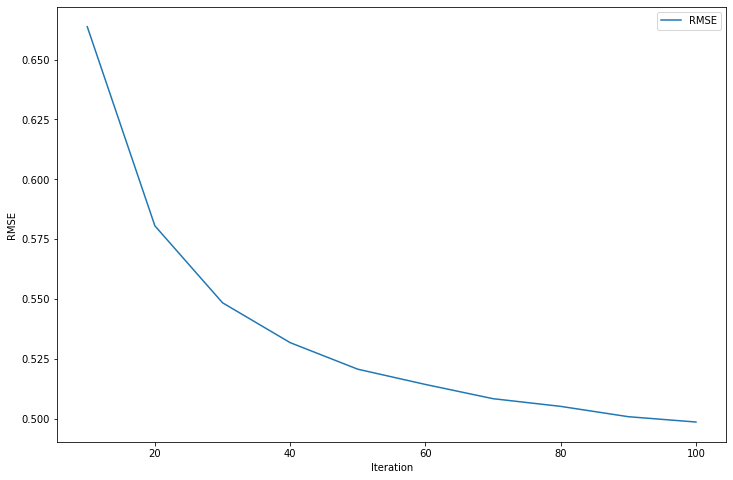

CPU times: user 18min 17s, sys: 10.8 s, total: 18min 28s
Wall time: 18min 20s


In [22]:
%%time
model_svds = SVDS(64, iterations=100, lr=1e-2, verbose=True, weight_decay=1e-2, save_every=10)

model_svds.fit(user_item_exp)

timestamp = datetime.now()
model_svds.logger.save(f"log.{timestamp.date()}_{timestamp.time()}.csv")
model_svds.logger.plot("iter", "rmse", label="RMSE", x_label="Iteration", y_label="RMSE")

## Задание 2. Не использую готовые решения, реализовать матричное разложение используя ALS на implicit данных

Iter:   10 | RMSE: 6.38586E-01
Iter:   20 | RMSE: 6.38249E-01
Iter:   30 | RMSE: 6.38173E-01
Iter:   40 | RMSE: 6.38138E-01
Iter:   50 | RMSE: 6.38126E-01
Iter:   60 | RMSE: 6.38122E-01
Iter:   70 | RMSE: 6.38119E-01
Iter:   80 | RMSE: 6.38116E-01
Iter:   90 | RMSE: 6.38114E-01
Iter:  100 | RMSE: 6.38111E-01


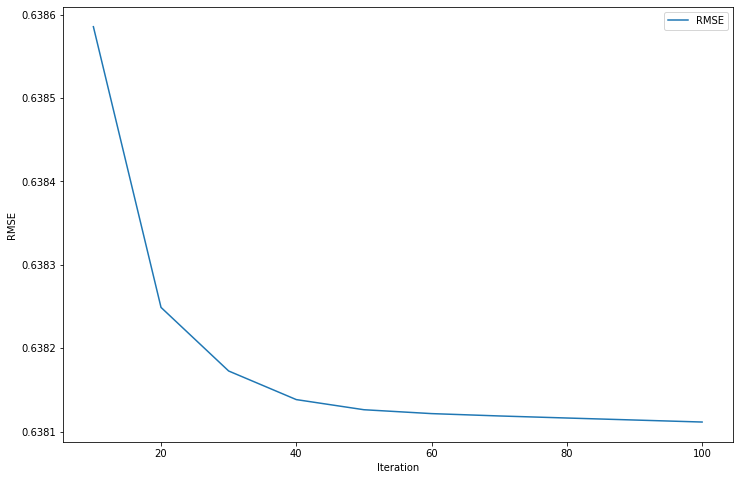

CPU times: user 1h 7min 45s, sys: 1h 24min 55s, total: 2h 32min 41s
Wall time: 19min 7s


In [23]:
%%time
model_als = ALS(64, 100, 1e-5, 1e-5, True)

model_als.fit(user_item_csr)

timestamp = datetime.now()
model_als.logger.save(f"log.{timestamp.date()}_{timestamp.time()}.csv")
model_als.logger.plot("iter", "rmse", label="RMSE", x_label="Iteration", y_label="RMSE")

# Note

в последующих алгоритмах используется ROC AUC в качестве метрики: их тут 2 штуки, одна -- честный roc auc из sklearn, а вторая -- с лекции.

## Задание 3. Не использую готовые решения, реализовать матричное разложение BPR на implicit данных

Iter:   1000 | AUC: 0.76568 | AUC2: 0.67969
Iter:   2000 | AUC: 0.93031 | AUC2: 0.82015
Iter:   3000 | AUC: 0.94574 | AUC2: 0.86788
Iter:   4000 | AUC: 0.95542 | AUC2: 0.90466
Iter:   5000 | AUC: 0.96044 | AUC2: 0.90207
Iter:   6000 | AUC: 0.96353 | AUC2: 0.91252
Iter:   7000 | AUC: 0.96566 | AUC2: 0.92822
Iter:   8000 | AUC: 0.96765 | AUC2: 0.90922
Iter:   9000 | AUC: 0.96910 | AUC2: 0.91418
Iter:  10000 | AUC: 0.97018 | AUC2: 0.93108


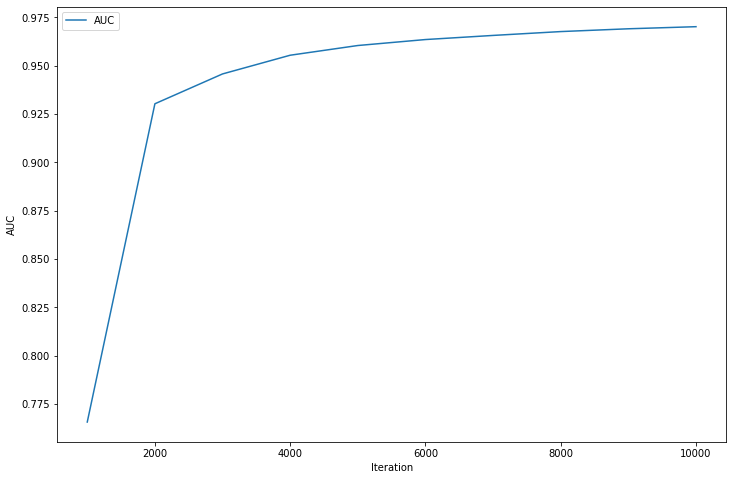

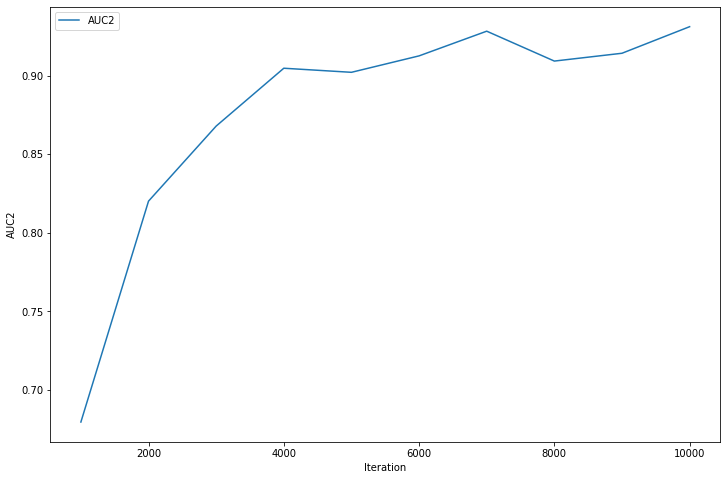

CPU times: user 16min 47s, sys: 8min 27s, total: 25min 14s
Wall time: 14min 53s


In [24]:
%%time
model_bpr = BPR(64, 10_000, 1e-2, 1e-2, True)

model_bpr.fit(user_item_csr, batch_size=3000)

timestamp = datetime.now()
model_bpr.logger.save(f"log.{timestamp.date()}_{timestamp.time()}.csv")
model_bpr.logger.plot("iter", "AUC", label="AUC", x_label="Iteration", y_label="AUC")
model_bpr.logger.plot("iter", "AUC2", label="AUC2", x_label="Iteration", y_label="AUC2")

## Задание 4. Не использую готовые решения, реализовать матричное разложение WARP на implicit данных

Iter:  1000000 | AUC: 0.86500 | AUC2: 0.72383
Iter:  2000000 | AUC: 0.91529 | AUC2: 0.77236
Iter:  3000000 | AUC: 0.92868 | AUC2: 0.81758
Iter:  4000000 | AUC: 0.94079 | AUC2: 0.86376
Iter:  5000000 | AUC: 0.95029 | AUC2: 0.86676
Iter:  6000000 | AUC: 0.95696 | AUC2: 0.89569
Iter:  7000000 | AUC: 0.96158 | AUC2: 0.90634
Iter:  8000000 | AUC: 0.96489 | AUC2: 0.92089
Iter:  9000000 | AUC: 0.96751 | AUC2: 0.92498
Iter:  10000000 | AUC: 0.96959 | AUC2: 0.92649


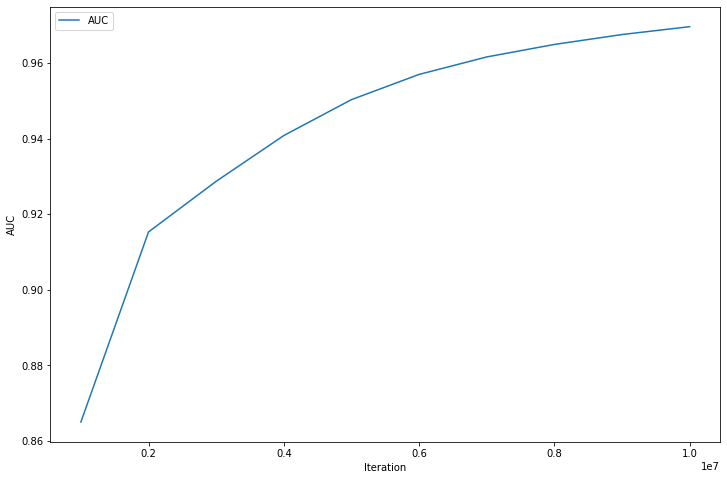

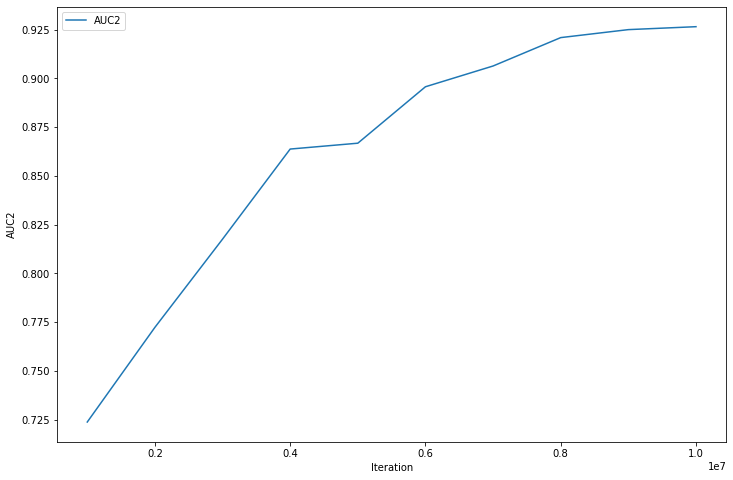

CPU times: user 50min 55s, sys: 8min 25s, total: 59min 20s
Wall time: 49min 1s


In [25]:
%%time
model_warp = WARP(64, 10_000_000, 1e-4, 1e-2, True)

model_warp.fit(user_item_csr)

timestamp = datetime.now()
model_warp.logger.save(f"log.{timestamp.date()}_{timestamp.time()}.csv")
model_warp.logger.plot("iter", "AUC", label="AUC", x_label="Iteration", y_label="AUC")
model_warp.logger.plot("iter", "AUC2", label="AUC2", x_label="Iteration", y_label="AUC2")

# Model testing

## SVD with GD

In [26]:
test(model_svd)

Similar to Toy Story (1995) (Animation|Children's|Comedy):
1) Toy Story 2 (1999) (Animation|Children's|Comedy)
2) Bug's Life, A (1998) (Animation|Children's|Comedy)
3) Aladdin (1992) (Animation|Children's|Comedy|Musical)
4) Sixth Sense, The (1999) (Thriller)
5) Wrong Trousers, The (1993) (Animation|Comedy)
6) Raiders of the Lost Ark (1981) (Action|Adventure)
7) Beauty and the Beast (1991) (Animation|Children's|Musical)
8) Schindler's List (1993) (Drama|War)
9) Apollo 13 (1995) (Drama)
10) Lion King, The (1994) (Animation|Children's|Musical)

Recommended movies for user 4:
1) Lady Eve, The (1941) (Comedy|Romance)
2) Grapes of Wrath, The (1940) (Drama)
3) Godfather: Part II, The (1974) (Action|Crime|Drama)
4) Casablanca (1942) (Drama|Romance|War)
5) Godfather, The (1972) (Action|Crime|Drama)
6) Animal House (1978) (Comedy)
7) High Noon (1952) (Western)
8) French Connection, The (1971) (Action|Crime|Drama|Thriller)
9) Citizen Kane (1941) (Drama)
10) Topsy-Turvy (1999) (Drama)


## SDV with (extremely) stochastic GD

In [27]:
test(model_svds)

Similar to Toy Story (1995) (Animation|Children's|Comedy):
1) Toy Story 2 (1999) (Animation|Children's|Comedy)
2) Bug's Life, A (1998) (Animation|Children's|Comedy)
3) Wrong Trousers, The (1993) (Animation|Comedy)
4) Aladdin (1992) (Animation|Children's|Comedy|Musical)
5) Raiders of the Lost Ark (1981) (Action|Adventure)
6) Close Shave, A (1995) (Animation|Comedy|Thriller)
7) End of the Affair, The (1955) (Drama)
8) Beauty and the Beast (1991) (Animation|Children's|Musical)
9) Sixth Sense, The (1999) (Thriller)
10) Lion King, The (1994) (Animation|Children's|Musical)

Recommended movies for user 4:
1) Lady Eve, The (1941) (Comedy|Romance)
2) Grapes of Wrath, The (1940) (Drama)
3) American Graffiti (1973) (Comedy|Drama)
4) Simple Plan, A (1998) (Crime|Thriller)
5) Animal House (1978) (Comedy)
6) 42 Up (1998) (Documentary)
7) Burnt By the Sun (Utomlyonnye solntsem) (1994) (Drama)
8) All Quiet on the Western Front (1930) (War)
9) Casablanca (1942) (Drama|Romance|War)
10) Thin Man, The (19

## ALS

In [28]:
test(model_als)

Similar to Toy Story (1995) (Animation|Children's|Comedy):
1) Toy Story 2 (1999) (Animation|Children's|Comedy)
2) Bug's Life, A (1998) (Animation|Children's|Comedy)
3) Aladdin (1992) (Animation|Children's|Comedy|Musical)
4) Lion King, The (1994) (Animation|Children's|Musical)
5) Babe (1995) (Children's|Comedy|Drama)
6) Hercules (1997) (Adventure|Animation|Children's|Comedy|Musical)
7) Iron Giant, The (1999) (Animation|Children's)
8) Tarzan (1999) (Animation|Children's)
9) Pleasantville (1998) (Comedy)
10) Mulan (1998) (Animation|Children's)

Recommended movies for user 4:
1) Terminator 2: Judgment Day (1991) (Action|Sci-Fi|Thriller)
2) Butch Cassidy and the Sundance Kid (1969) (Action|Comedy|Western)
3) Matrix, The (1999) (Action|Sci-Fi|Thriller)
4) Indiana Jones and the Last Crusade (1989) (Action|Adventure)
5) Aliens (1986) (Action|Sci-Fi|Thriller|War)
6) Star Wars: Episode V - The Empire Strikes Back (1980) (Action|Adventure|Drama|Sci-Fi|War)
7) Fugitive, The (1993) (Action|Thriller

## BPR

In [29]:
test(model_bpr)

Similar to Toy Story (1995) (Animation|Children's|Comedy):
1) Thumbelina (1994) (Animation|Children's)
2) Rugrats Movie, The (1998) (Animation|Children's|Comedy)
3) Muppet Movie, The (1979) (Children's|Comedy)
4) Home Alone 3 (1997) (Children's|Comedy)
5) George of the Jungle (1997) (Children's|Comedy)
6) Jungle2Jungle (a.k.a. Jungle 2 Jungle) (1997) (Children's|Comedy)
7) Rescuers, The (1977) (Animation|Children's)
8) D2: The Mighty Ducks (1994) (Children's|Comedy)
9) Aladdin (1992) (Animation|Children's|Comedy|Musical)
10) MatchMaker, The (1997) (Comedy|Romance)

Recommended movies for user 4:
1) French Connection, The (1971) (Action|Crime|Drama|Thriller)
2) Godfather: Part II, The (1974) (Action|Crime|Drama)
3) Ben-Hur (1959) (Action|Adventure|Drama)
4) Godfather, The (1972) (Action|Crime|Drama)
5) Aliens (1986) (Action|Sci-Fi|Thriller|War)
6) Dirty Dozen, The (1967) (Action|War)
7) Star Wars: Episode V - The Empire Strikes Back (1980) (Action|Adventure|Drama|Sci-Fi|War)
8) Fugitive

## WARP

In [30]:
test(model_warp)

Similar to Toy Story (1995) (Animation|Children's|Comedy):
1) Pleasantville (1998) (Comedy)
2) Aladdin (1992) (Animation|Children's|Comedy|Musical)
3) Toy Story 2 (1999) (Animation|Children's|Comedy)
4) Groundhog Day (1993) (Comedy|Romance)
5) Muppet Movie, The (1979) (Children's|Comedy)
6) Babe (1995) (Children's|Comedy|Drama)
7) Lion King, The (1994) (Animation|Children's|Musical)
8) Clueless (1995) (Comedy|Romance)
9) Austin Powers: International Man of Mystery (1997) (Comedy)
10) Beauty and the Beast (1991) (Animation|Children's|Musical)

Recommended movies for user 4:
1) Godfather, The (1972) (Action|Crime|Drama)
2) Star Wars: Episode V - The Empire Strikes Back (1980) (Action|Adventure|Drama|Sci-Fi|War)
3) Godfather: Part II, The (1974) (Action|Crime|Drama)
4) Terminator 2: Judgment Day (1991) (Action|Sci-Fi|Thriller)
5) Aliens (1986) (Action|Sci-Fi|Thriller|War)
6) Fugitive, The (1993) (Action|Thriller)
7) Braveheart (1995) (Action|Drama|War)
8) Psycho (1960) (Horror|Thriller)
9

В целом, усе работает! Субъективно, мне ALS понравился больше, так как обучается стабильнее и видно потенциальные места для параллелизации. С другой стороны, кажется, у BPR рекомендации фильмов для пользователя получше выглядят, но у меня он почему-то обучается не очень стабильно, хотя тот же WARP уже более стабильно себя ведет... хотя, конечно, можно больше поиграться с гиперпараметрами